In [62]:
import os
import sys
import h5py
from tqdm import tqdm 
import numpy as np
import torch
# import BART
os.environ['TOOLBOX_PATH'] = "/home/svangurp/scratch/samuel/bart-0.6.00/"
sys.path.append('/home/svangurp/scratch/samuel/bart-0.6.00/python/')
import bart
import fastmri.data.transforms as T
from fastmri.data.subsample import create_mask_for_mask_type
from fastmri import tensor_to_complex_np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# BART parallel imaging compressed sensing

In [76]:
def pics_func(kspace, slice, crop_size, device, reg_wt, num_iters):
    
    ## PREPROSESSING 
#     print('Preprosessing ')
    
    # normalise the im-space that transform back to k-space
    imspace = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(kspace, axes=(-2, -1)), axes=(-2, -1)), axes=(-2, -1))
    imspace = T.center_crop(imspace, crop_size) 
    imspace = imspace / np.max(np.abs(imspace))

    kspace = np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(imspace, axes=(-2, -1)), axes=(-2, -1)), axes=(-2, -1))
    
    # RSS coil combination for the target image
    target = np.sqrt(np.sum(imspace**2, 1))
    target = target / np.max(np.abs(target))
    
    # creating the mask and masking kaspace
    mask_func = create_mask_for_mask_type(mask_type_str="random", center_fractions=[0.08], accelerations=[4])
    masked_kspace, mask = T.apply_mask(T.to_tensor(kspace), mask_func)
    masked_kspace = torch.view_as_complex(masked_kspace)

    # baseline reconstruction (just leaving the masked data point out)
    linear_recon = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(masked_kspace.detach().cpu().numpy(), 
                                                                 axes=(-2, -1)), axes=(-2, -1)), axes=(-2, -1))
    linear_recon = np.sqrt(np.sum(linear_recon ** 2, 1))
    linear_recon = linear_recon / np.max(np.abs(linear_recon))
#     print('Preprosessing  done')
    
    ## estimate the coil sensitivity maps
#     print('sens map estimation')
    _masked_kspace = masked_kspace.permute(0, 2, 3, 1).detach().cpu().numpy() # step to get kspace in a form that bart expects 
    sens_maps = bart.bart(1, "ecalib -d0 -m1", _masked_kspace) 
#     print('sens map estimation done')
    
    tmp_sens_maps = np.fft.ifft2(np.fft.fftshift(np.fft.fft2(sens_maps[slice], axes=(-3, -2)), axes=(-3, -2)), axes=(-3, -2))
    tmp_imspace = np.fft.ifft2(np.fft.fftshift(_masked_kspace[slice], axes=(-3, -2)), axes=(-3, -2))
    tmp_target = np.sum(tmp_imspace*tmp_sens_maps.conj(), -1)
    
    ## RUNNING BART
#     print('Running bart')
    reg_wt = reg_wt
    num_iters = num_iters

    tmp_masked_kspace = np.fft.fftshift(np.expand_dims(_masked_kspace[slice], 0), axes=(-3, -2))

    pred = np.abs(bart.bart(1, f"pics -d0 -S -R T:7:0:{reg_wt} -i {num_iters}", 
                            tmp_masked_kspace, np.expand_dims(sens_maps[slice], 0)))
    pred = np.abs(pred[0])
    
#     print('Running bart done')
    
    
    return target[slice], linear_recon[slice], pred

In [49]:
fname = '/scratch/svangurp/samuel/data/knee/train/file1000002.h5'
data = h5py.File(fname, 'r')
kspace = data["kspace"][()]
slice = 20

In [50]:
target, lin_recon, pred = pics_func(kspace, slice = 20, crop_size = (320,320), device ='cuda', reg_wt = 0.01, num_iters = 20)

Preprosessing 
Preprosessing  done
sens map estimation
sens map estimation done
Running bart
Running bart done


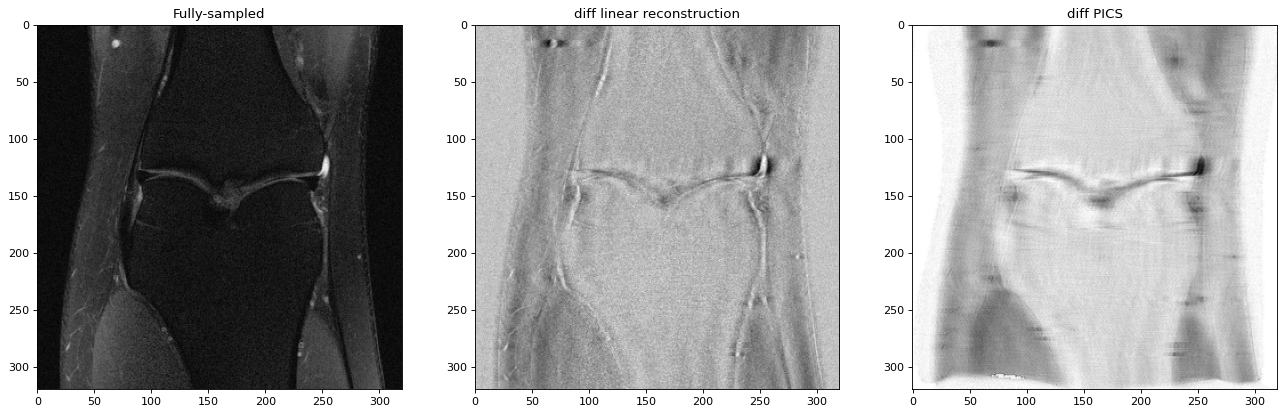

In [86]:
plt.figure(figsize=(20,18), dpi = 80)
plt.subplot(1, 3, 1)
plt.imshow(np.abs(target), cmap='gray')
plt.title('Fully-sampled')
plt.subplot(1, 3, 2)
plt.imshow(np.abs(target)-np.abs(lin_recon), cmap='gray')
plt.title('diff linear reconstruction')
plt.subplot(1, 3, 3)
plt.imshow(np.abs(target)-np.abs(pred), cmap='gray')
plt.title('diff PICS')

plt.show()

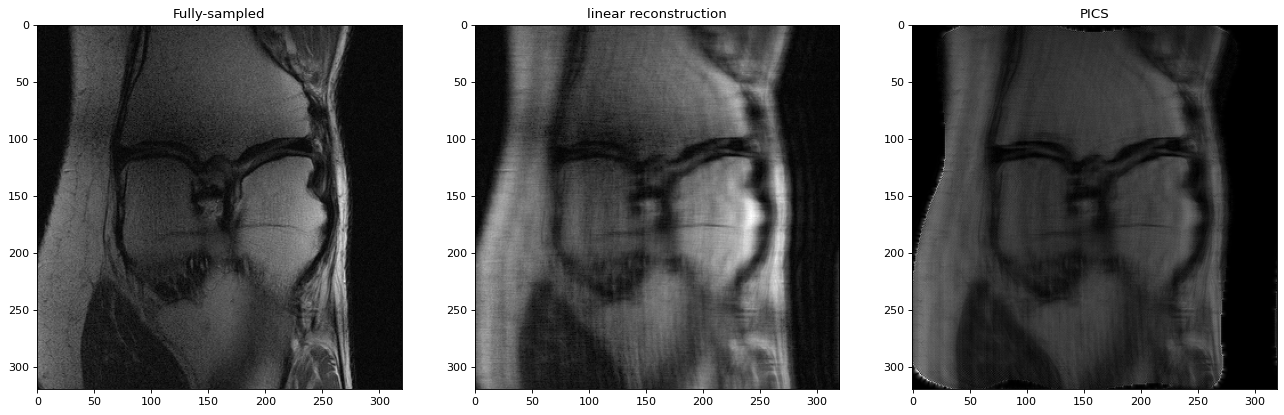

In [102]:
plt.figure(figsize=(20,18), dpi = 80)
plt.subplot(1, 3, 1)
plt.imshow(np.abs(target), cmap='gray')
plt.title('Fully-sampled')
plt.subplot(1, 3, 2)
plt.imshow(np.abs(lin_recon), cmap='gray')
plt.title('linear reconstruction')
plt.subplot(1, 3, 3)
plt.imshow(np.abs(pred), cmap='gray')
plt.title('PICS')

plt.show()

In [107]:
# _target = np.expand_dims(np.abs(target[slice]), -1)
_target = target / np.max(np.abs(target))

# _pred = np.expand_dims(np.abs(pred[slice]), -1)
_pred = pred / np.max(np.abs(pred))

# _linear_recon = np.expand_dims(np.abs(lin_recon[slice]), -1)
_linear_recon = lin_recon / np.max(np.abs(lin_recon))

print(np.max(_target), np.max(_pred), np.max(_linear_recon))


SSIM_pics =      structural_similarity(np.abs(_target), np.abs(_pred), data_range=np.max(_target), multichannel=True)
SSIM_lin_recon = structural_similarity(np.abs(_target), np.abs(_linear_recon), data_range=np.max(_target), multichannel=True)

print('SSIM_pics:',SSIM_pics)
print('SSIM_lin_recon:', SSIM_lin_recon)

(0.7784327952086665-0.09301002920248512j) 1.0 (0.6977938936979554+0.1260323257710215j)
SSIM_pics: 0.4227603618083153
SSIM_lin_recon: 0.606273538345472


/scratch/svangurp/envs/fastMRI/lib/python3.8/site-packages/skimage/metrics/_structural_similarity.py:116: ComplexWarning: Casting complex values to real discards the imaginary part
  mssim[..., ch] = ch_result


In [ ]:

os.chdir('/data/projects/recon/data/public/fastmri/knee/multicoil/multicoil_val/')
SSIM_pics_list = []
SSIM_lin_recon_list = []

for i in tqdm(os.listdir()):
    
    data = h5py.File(i, 'r')
    kspace = data["kspace"][()]
    target, lin_recon, pred = pics_func(kspace, slice = 20, crop_size = (320,320), device ='cuda', reg_wt = 0.01, num_iters = 20)

    # normalising 
    _target = target / np.max(np.abs(target))
    _pred = pred / np.max(np.abs(pred))
    _linear_recon = lin_recon / np.max(np.abs(lin_recon))

    SSIM_pics =      structural_similarity(np.abs(_target), np.abs(_pred), data_range=np.max(_target), multichannel=True)
    SSIM_lin_recon = structural_similarity(np.abs(_target), np.abs(_linear_recon), data_range=np.max(_target), multichannel=True)


    SSIM_pics_list.append(SSIM_pics)
    SSIM_lin_recon_list.append(SSIM_lin_recon)


  0%|          | 0/199 [00:00<?, ?it/s]/scratch/svangurp/envs/fastMRI/lib/python3.8/site-packages/skimage/metrics/_structural_similarity.py:116: ComplexWarning: Casting complex values to real discards the imaginary part
  mssim[..., ch] = ch_result
 90%|█████████ | 180/199 [8:42:01<54:55, 173.46s/it]  

In [120]:
print(np.mean(SSIM_pics_list))
print(np.mean(SSIM_lin_recon_list))

0.4769539495802789
0.6165922589309012


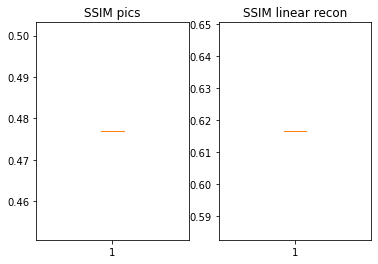

In [121]:

plt.subplot(1,2,1)
plt.boxplot(SSIM_pics_list)
plt.title('SSIM pics')
plt.subplot(1,2,2)
plt.title('SSIM linear recon')
plt.boxplot(SSIM_lin_recon_list)
plt.show()